<a href="https://colab.research.google.com/github/AMRowe99/ECS_Class/blob/main/MECH_450C_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to TESPy**
* Welcome to the TESPy component of Assignment 4, where you will learn how to use the process simulation tool TESPy (Thermal Engineering Systems in Python) to do exergy analysis.
* In this assignment, we will dive deep into the Rankine cycle that converts thermal energy into mechanical work, and is common at power plants.
* 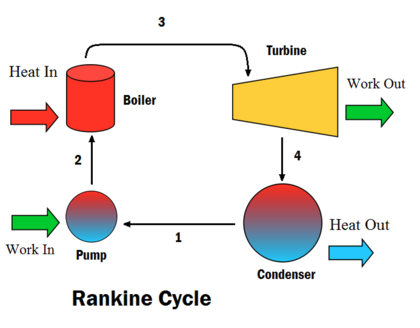

**What is TESPy?**
* TESPy is a process simulation framework that models, analyzes, and optimizes thermodynamic systems including power plants, refrigeration cycles, and production operations.
* It uses a system of equations to build a digital model of a process, which is then solved to predict:
1. Energy and mass flows
2. Fluid pressures and temperatures
3. System efficiencies
* TESPy is used by engineers to evaluate system configurations before physical prototyping. Some examples of use cases include:
1. Minimizing fuel consumption in a power plant
2. Maximizing the coefficient of performance (COP) in a refrigeration cycle
3. Reducing or using waste heat

**Why TESPy?**
* Compared to proprietary process simulation tools (Aspen HYSYS - $30K per license per annum), TESPy is an open-source, Python-based tool that is readily available for students and researchers. It is (relatively) easy to learn and use, with a versatile framework that allows significant customization.
* It has excellent integration with the Python ecosystem, including packages such as NumPy, Pandas, Matplotlib, etc.
* But, you get what you pay for: it does not model chemical conversion processes (except combustion), has limited tech support, and

**How does TESPy work?**
* TESPy is composed of (1) components and (2) fluids.
* A component is defined using equations that govern energy / entropy balances, as well as physical constraints such as heat transfer coefficients, isentropic efficiences, etc.
* A fluid is defined using physical properties such as pressure, temperature, flow rate, density, etc. as well as chemical properties that are drawn from CoolProp.
* TESPy solves the system equations iteratively until convergence is achieved for unknown parameters.

**How will this assignment work?**
* A Rankine cycle will be modelled for you with starting parameters that are less than ideal. You will change input parameters (component efficiencies, fluid properties) to improve the total system efficiency (i.e., reduce exergetic waste).
* The model will be broken down into code blocks for explanations and to simplify running it since you will need to rerun it several times.

**Code Block 1**
* In this block, we will call the TESPy package and load it into Google Collab.
* You only need to run this block once.


In [ ]:
# Code Block 1
!pip install tespy
!pip install fluprodia
import tespy

**Code Block 2**
* In this block, we set up the model structure by specifying the components used and the units.
* For the Rankine cycle, we will need a steam generator, a turbine, a condenser, and a pump.
* There are a few types of heat exchangers pre-defined in TESPy. The steam generator is modelled using a 'simple heat exchanger' with only one fluid (water) and energy input (heat in) - technically this is not a heat exchanger, and includes equipment like fired heaters and electric boilers. The condenser is modelled using a 'regular heat exchanger' with two fluids in a counter- or cross-flow configuration. The condenser, therefore, is a part of two processes: the primary Rankine cycle, and the secondary cooling loop.
* TESPy only has one pre-defined turbine and pump.
* There are also a few "components" used to complete the mathematical formulation:
1. A 'Cycle Closer' is placed at the start / end of a cycle.
2. A 'Source' and 'Sink' is used when we do not want to (or cannot) model a cycle. For example, we are not refining the design of the cooling water loop in the condenser, so we simply provide a source and sink for the cooling water.
* The steps involved are:
1. Define the entire plant as a "network" using the Network() function.
2. Set the units - in this case SI.
3. Call the component types from the tespy.components module.
4. Specify individual components unique to your model.

In [ ]:
# Code Block 2
from tespy.networks import Network

# create a network
my_plant = Network()
my_plant.units.set_defaults(
    temperature="degC", pressure="bar", enthalpy="kJ/kg", power="MW", heat="MW"
)
# import components
from tespy.components import (
    CycleCloser, Pump, Condenser, Turbine, SimpleHeatExchanger, Source, Sink
)

# generate names for individual components
cc = CycleCloser('cycle closer')
sg = SimpleHeatExchanger('steam generator')
mc = Condenser('main condenser')
tu = Turbine('steam turbine')
fp = Pump('feed pump')
cwso = Source('cooling water source')
cwsi = Sink('cooling water sink')

**Code Block 3**
* One of the disadvantages of TESPy is that it does not have a GUI like Aspen HYSYS. However, designing a process loop is fairly simple and involves connecting components in series. A "connection" connects the output of one component to the input of another.
* In this model, all of the components are connected to the next directly. This tells us that we are assuming a pressure and temperature loss of zero in intermediate piping.
* Once the connections are defined, a process loop is constructed with the my_plant.add_conns() function where we specify the sequence of connections. Here, we see that there are indeed two process loops: the primary Rankine cycle, and the secondary cooling water loop.

In [ ]:
# Code Block 3
from tespy.connections import Connection

c1 = Connection(cc, 'out1', tu, 'in1', label='1')
c2 = Connection(tu, 'out1', mc, 'in1', label='2')
c3 = Connection(mc, 'out1', fp, 'in1', label='3')
c4 = Connection(fp, 'out1', sg, 'in1', label='4')
c0 = Connection(sg, 'out1', cc, 'in1', label='0')

my_plant.add_conns(c1, c2, c3, c4, c0)

c11 = Connection(cwso, 'out1', mc, 'in2', label='11')
c12 = Connection(mc, 'out2', cwsi, 'in1', label='12')

my_plant.add_conns(c11, c12)

**Code Block 4**
* In this block, we will set the component and fluid parameters that we know. It is important to note that as an equations solver, we must specify only the correct number of knowns. If we overspecify parameters, the model is "over-constrained" and cannot solve; and if do not specify enough parameters, the model is "under-constrained".
* Most headaches come from over- or under-constraining the model.
* For the components, we specify mechanical design properties. Specifically:
1. For the steam generator, the pressure drop across the tubes is 10%.
2. For the condenser, the pressure drop across the process side (Rankine cycle) is negligible, while the pressure drop across the utility side (cooling water loop) is 2%.
3. For the turbine, the isentropic efficiency is 90%.
4. For the pump, the isentropic efficiency is 75%.
* Fluid properties are set at the connections. That is, we specify the states at which we want the fluids to be (or expect to be) at the connections between components. For the primary Rankine cycle, this is:
1. At c1, high pressure steam is entering the turbine at T = 430 C, P = 85 bar, and a flow rate of 10 kg/hr. Note that the unit of mass flow rate is undefined, so kg/hr is inferred. Of course, the fluid is 100% 'water' defined using the fluid={} function.
2. At c2, low pressure steam is exiting the turbine at P = 0.1 bar.
* This tells us that the Ranking cycle (and by extension, the entire system including the cooling water loop) is governed by the turbine design. In fact, this is how chemical processes are designed in the real world - we start with the critical component from where the rest of the design cascades.
* Of course, we must not forget the secondary cooling water loop:
1. At c11, cold water is coming in at T = 20 C, P = 1.2 bar, and an indeterminate flow rate.
2. At c12, warm water is coming out at T = 30 C.
* This formulation further confirms that the system design is governed by the turbine. By not specifying the cooling water mass flow rate, we are letting the model decide the size of our condenser.
* For this assignment, you will only need to change values in this block.

In [ ]:
# Code Block 4
mc.set_attr(pr1=1, pr2=0.98)
sg.set_attr(pr=0.9)
tu.set_attr(eta_s=0.9)
fp.set_attr(eta_s=0.75)

c11.set_attr(T=20, p=1.2, fluid={'water': 1})
c12.set_attr(T=30)
c1.set_attr(T=430, p=85, m=10, fluid={'water': 1})
c2.set_attr(p=0.1)

**Code Block 5**
* Finally, we run the model using the .solve() function.
* The solutions are printed below. Blue text identifies user inputs, while white (dark mode) or black (light mode) text shows the results of the calculations.
* Few items of note: in the backend we can specify the maximum number of iterations before the model is forced to give up. A simple model like this can generally solve (i.e. achieve 100% convergence) within 7-8 iterations.
* Let's read through the results (your numbers might be slightly off - since there is a very slight error margin allowed for convergence).
* For the components:
1. Pump. *dp* is the inlet-to-outlet pressure difference; *pr* is the oulet-to-inlet pressure ratio. A *dp* of -94.3 bar means that the pump increases fluid pressure by 94.3 bar. A *pr* of 944 means that the inlet pressure can be calculated as 0.1 bar. Remember how we specified the oulet pressure of the turbine as 0.1 bar? Well, we also assumed that the pressure drop across the hot side of the condenser was zero, so the TESPy result is valid. Also note that *P*, which stands for power consumed, is 0.127 MW.
2. Condenser. TESPy calculates heat exchanger design parameters that can be given to a manufacturer. These are: *kA* is the area independent heat transfer coefficient, *dp1* and *dp2* are inlet-to-outlet pressure differences for the hot- and cold-side respectively. *ttd_l, tt_u, ttd_min* are the terminal temperature differences. We also see heat exchanger effectiveness (*eff_cold, eff_heat*), and the total heat transfer *Q* of 19.7 MW to the cooling water.
3. Steam generator. There is a slight pressure drop (10%) from 94.3 bar to 85 bar. We also see the heat required is 30.1 MW.
4. Turbine. By extracting work from the steam, we see that the turbine is able to extract 10.5 MW of power.

In [ ]:
# Code Block 5
my_plant.solve(mode='design')
my_plant.print_results()

**Code Block 6**
* In this block, we will use Matplotlib and fluprodia to generate a TS-digram.

In [ ]:
# Adding feature to plot the T-s Diagram using fluprodia library
# Importing necessary library
import matplotlib.pyplot as plt
import numpy as np
from fluprodia import FluidPropertyDiagram

# Initial Setup
diagram = FluidPropertyDiagram('water')
diagram.set_unit_system(T='°C', p='bar', h='kJ/kg')

# Storing the model result in the dictionary
result_dict = {}
result_dict.update(
    {cp.label: cp.get_plotting_data()[1] for cp in my_plant.comps['object']
     if cp.get_plotting_data() is not None})

# Iterate over the results obtained from TESPy simulation
for key, data in result_dict.items():
    # Calculate individual isolines for T-s diagram
    result_dict[key]['datapoints'] = diagram.calc_individual_isoline(**data)

# Create a figure and axis for plotting T-s diagram
fig, ax = plt.subplots(1, figsize=(20, 10))
isolines = {
    'Q': np.linspace(0, 1, 2),
    'p': np.array([1, 2, 5, 10, 20, 50, 100, 300]),
    'v': np.array([]),
    'h': np.arange(500, 3501, 500)
}

# Set isolines for T-s diagram
diagram.set_isolines(**isolines)
diagram.calc_isolines()

# Draw isolines on the T-s diagram
diagram.draw_isolines(fig, ax, 'Ts', x_min=0, x_max=7500, y_min=0, y_max=650)

# Adjust the font size of the isoline labels
for text in ax.texts:
    text.set_fontsize(10)

# Plot T-s curves for each component
for key in result_dict.keys():
    datapoints = result_dict[key]['datapoints']
    _ = ax.plot(datapoints['s'], datapoints['T'], color='#ff0000', linewidth=2)
    _ = ax.scatter(datapoints['s'][0], datapoints['T'][0], color='#ff0000')

# Set labels and title for the T-s diagram
ax.set_xlabel('Entropy, s in J/kgK', fontsize=16)
ax.set_ylabel('Temperature, T in °C', fontsize=16)
ax.set_title('T-s Diagram of Rankine Cycle', fontsize=20)

# Set font size for the x-axis and y-axis ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()

# Save the T-s diagram plot as an SVG file
fig.savefig('rankine_ts_diagram.svg')

**Assignment 4 Questions**
* To rerun the model, you will need to run blocks 4, 5, and 6 several times.
1. What is the efficiency of the system?
2.